In [ ]:
!pip install gensim
!pip install keras
!pip install pandas

In [ ]:
# DataFrame
import pandas as pd

# Matplot
import matplotlib.pyplot as plt
%matplotlib inline

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer

# Keras
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# nltk
import nltk
from nltk.corpus import stopwords
from  nltk.stem import SnowballStemmer

# Word2vec
import gensim

# Utility
import re
import numpy as np
import os
from collections import Counter
import logging
import time
import pickle
import itertools

# Set log
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# DATASET
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = "ISO-8859-1"
TRAIN_SIZE = 0.8

# TEXT CLENAING
TEXT_CLEANING_RE = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"

# WORD2VEC
W2V_SIZE = 300
W2V_WINDOW = 7
W2V_EPOCH = 32
W2V_MIN_COUNT = 10

# KERAS
SEQUENCE_LENGTH = 300
EPOCHS = 8
BATCH_SIZE = 1024

# SENTIMENT
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# EXPORT
KERAS_MODEL = "model.h5"
WORD2VEC_MODEL = "model.w2v"
TOKENIZER_MODEL = "tokenizer.pkl"
ENCODER_MODEL = "encoder.pkl"

In [ ]:
dataset_path = "/content/drive/MyDrive/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(dataset_path, encoding =DATASET_ENCODING , names=DATASET_COLUMNS)
print("Dataset size:", len(df))


Dataset size: 1600000


In [ ]:
df.head(5)

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
%%time
df.target = df.target.apply(lambda x: decode_sentiment(x))

CPU times: user 753 ms, sys: 14.1 ms, total: 767 ms
Wall time: 915 ms


Text(0.5, 1.0, 'Dataset labels distribuition')

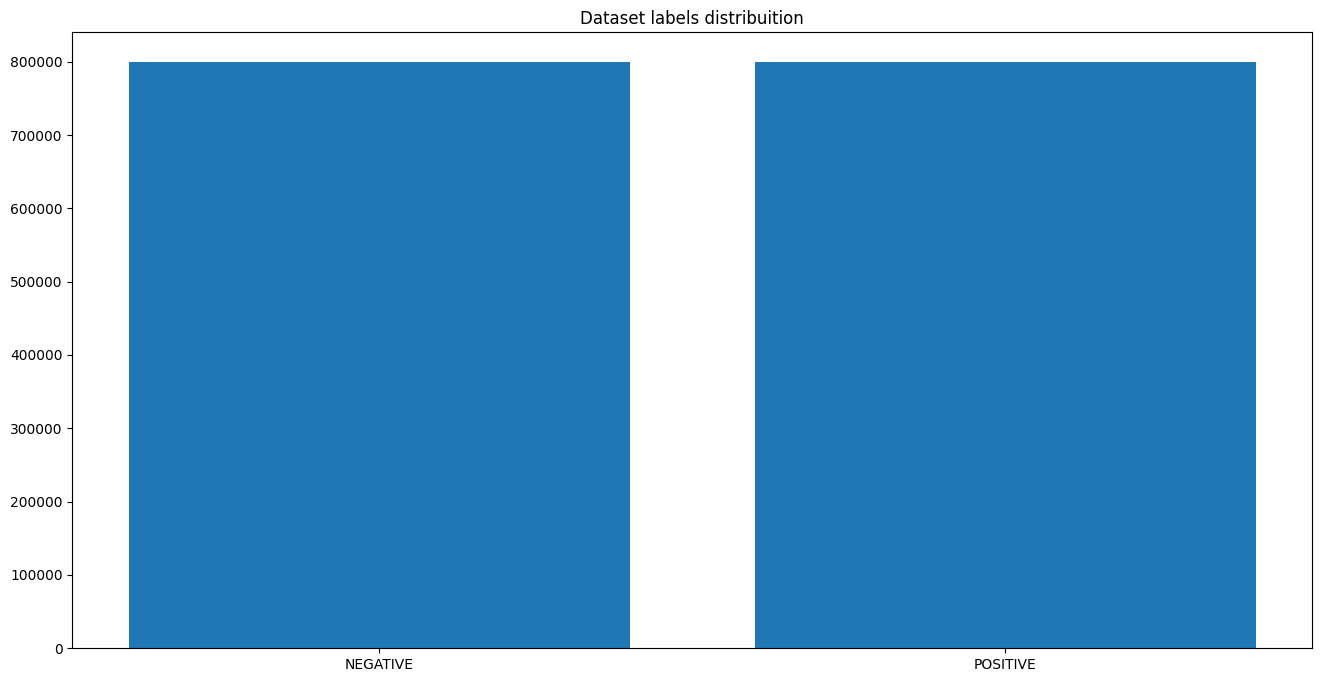

In [ ]:
target_cnt = Counter(df.target)

plt.figure(figsize=(16,8))
plt.bar(target_cnt.keys(), target_cnt.values())
plt.title("Dataset labels distribuition")

In [ ]:
stop_words = stopwords.words("english")
stemmer = SnowballStemmer("english")

In [ ]:
def preprocess(text, stem=False):
    # Remove link,user and special characters
    text = re.sub(TEXT_CLEANING_RE, ' ', str(text).lower()).strip()
    tokens = []
    for token in text.split():
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token))
            else:
                tokens.append(token)
    return " ".join(tokens)

In [ ]:
%%time
df.text = df.text.apply(lambda x: preprocess(x))

CPU times: user 59.6 s, sys: 308 ms, total: 59.9 s
Wall time: 1min 18s


In [ ]:
df_train, df_test = train_test_split(df, test_size=1-TRAIN_SIZE, random_state=42)
print("TRAIN size:", len(df_train))
print("TEST size:", len(df_test))

TRAIN size: 1280000
TEST size: 320000


In [ ]:
%%time
documents = [_text.split() for _text in df_train.text]

CPU times: user 3.45 s, sys: 323 ms, total: 3.78 s
Wall time: 3.77 s


In [ ]:
w2v_model = gensim.models.word2vec.Word2Vec(vector_size=W2V_SIZE,
                                            window=W2V_WINDOW,
                                            min_count=W2V_MIN_COUNT,
                                            workers=8)

In [ ]:
w2v_model.build_vocab(documents)

In [ ]:
words = w2v_model.wv.key_to_index.keys()
vocab_size = len(words)
print("Vocab size", vocab_size)

Vocab size 30369


In [ ]:
%%time
w2v_model.train(documents, total_examples=len(documents), epochs=W2V_EPOCH)

CPU times: user 18min 33s, sys: 4.8 s, total: 18min 38s
Wall time: 11min 8s


(263129665, 295270528)

In [ ]:
w2v_model.wv.most_similar("love")

[('luv', 0.5831403732299805),
 ('loves', 0.5569003820419312),
 ('loved', 0.5385382771492004),
 ('adore', 0.51578688621521),
 ('amazing', 0.5013832449913025),
 ('looove', 0.4780477285385132),
 ('awesome', 0.4689388573169708),
 ('lovee', 0.44245004653930664),
 ('loooove', 0.43804916739463806),
 ('loveee', 0.43621766567230225)]

In [ ]:
%%time
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train.text)

vocab_size = len(tokenizer.word_index) + 1
print("Total words", vocab_size)

Total words 290419
CPU times: user 17 s, sys: 194 ms, total: 17.2 s
Wall time: 17.2 s


In [ ]:
%%time
x_train = pad_sequences(tokenizer.texts_to_sequences(df_train.text), maxlen=SEQUENCE_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(df_test.text), maxlen=SEQUENCE_LENGTH)

CPU times: user 23.9 s, sys: 542 ms, total: 24.4 s
Wall time: 24.5 s


In [ ]:
labels = df_train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
encoder = LabelEncoder()
encoder.fit(df_train.target.tolist())

y_train = encoder.transform(df_train.target.tolist())
y_test = encoder.transform(df_test.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

print("y_train",y_train.shape)
print("y_test",y_test.shape)

y_train (1280000, 1)
y_test (320000, 1)


In [ ]:
print("x_train", x_train.shape)
print("y_train", y_train.shape)
print()
print("x_test", x_test.shape)
print("y_test", y_test.shape)

x_train (1280000, 300)
y_train (1280000, 1)

x_test (320000, 300)
y_test (320000, 1)


In [ ]:
y_train[:10]


array([[1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [1],
       [1]])

In [ ]:
embedding_matrix = np.zeros((vocab_size, W2V_SIZE))
for word, i in tokenizer.word_index.items():
  if word in w2v_model.wv:
    embedding_matrix[i] = w2v_model.wv[word]
print(embedding_matrix.shape)

(290419, 300)


In [ ]:
embedding_layer = Embedding(vocab_size, W2V_SIZE, weights=[embedding_matrix], input_length=SEQUENCE_LENGTH, trainable=False)

In [ ]:
model = Sequential()
model.add(embedding_layer)
model.add(Dropout(0.5))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          87125700  
                                                                 
 dropout (Dropout)           (None, 300, 300)          0         
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 87286201 (332.97 MB)
Trainable params: 160501 (626.96 KB)
Non-trainable params: 87125700 (332.36 MB)
_________________________________________________________________


In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [ ]:
callbacks = [ ReduceLROnPlateau(monitor='val_loss', patience=5, cooldown=0),
              EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)]

In [ ]:
%%time
history = model.fit(x_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_split=0.1,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/8
1125/1125 [==============================] - 551s 483ms/step - loss: 0.5038 - accuracy: 0.7506 - val_loss: 0.4671 - val_accuracy: 0.7787 - lr: 0.0010
Epoch 2/8
1125/1125 [==============================] - 538s 478ms/step - loss: 0.4786 - accuracy: 0.7676 - val_loss: 0.4602 - val_accuracy: 0.7832 - lr: 0.0010
Epoch 3/8
1125/1125 [==============================] - 536s 476ms/step - loss: 0.4714 - accuracy: 0.7723 - val_loss: 0.4525 - val_accuracy: 0.7869 - lr: 0.0010
Epoch 4/8
1125/1125 [==============================] - 542s 482ms/step - loss: 0.4676 - accuracy: 0.7744 - val_loss: 0.4508 - val_accuracy: 0.7876 - lr: 0.0010
Epoch 5/8
1125/1125 [==============================] - 541s 481ms/step - loss: 0.4651 - accuracy: 0.7762 - val_loss: 0.4493 - val_accuracy: 0.7896 - lr: 0.0010
Epoch 6/8
1125/1125 [==============================] - 547s 486ms/step - loss: 0.4631 - accuracy: 0.7775 - val_loss: 0.4483 - val_accuracy: 0.7897 - lr: 0.0010
Epoch 7/8
1125/1125 [===================

In [ ]:
%%time
score = model.evaluate(x_test, y_test, batch_size=BATCH_SIZE)
print()
print("ACCURACY:",score[1])
print("LOSS:",score[0])

313/313 [==============================] - 35s 109ms/step - loss: 0.4458 - accuracy: 0.7915

ACCURACY: 0.7914875149726868
LOSS: 0.44577139616012573
CPU times: user 29.9 s, sys: 3.25 s, total: 33.1 s
Wall time: 41.9 s


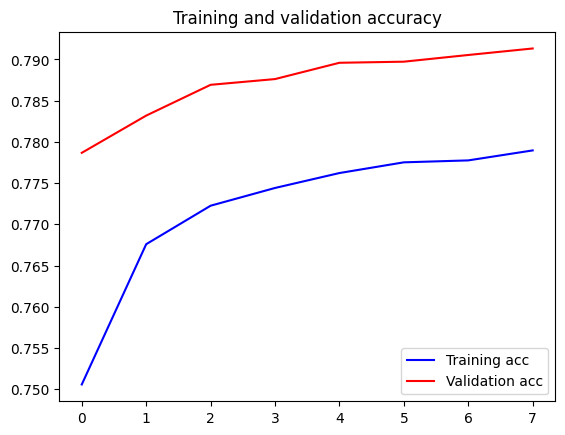

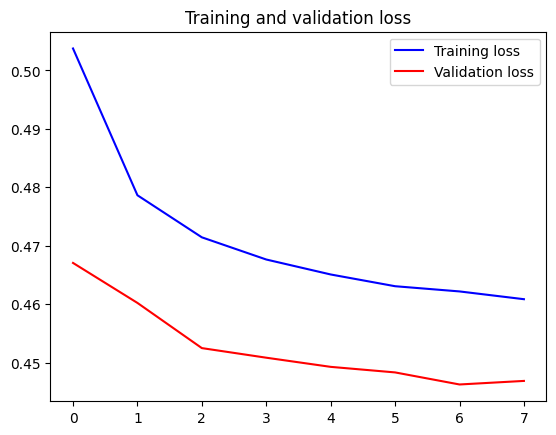

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
def decode_sentiment(score, include_neutral=True):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def predict(text, include_neutral=True):
    start_at = time.time()
    # Tokenize text
    x_test = pad_sequences(tokenizer.texts_to_sequences([text]), maxlen=SEQUENCE_LENGTH)
    # Predict
    score = model.predict([x_test])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score),
       "elapsed_time": time.time()-start_at}

In [ ]:
predict("I love the music")


1/1 [==============================] - 0s 315ms/step


{'label': 'POSITIVE',
 'score': 0.9705411195755005,
 'elapsed_time': 0.3596925735473633}

In [ ]:
predict("I hate the rain")


1/1 [==============================] - 0s 91ms/step


{'label': 'NEGATIVE',
 'score': 0.011328526772558689,
 'elapsed_time': 0.13931632041931152}

In [ ]:
predict("i don't know what i'm doing")


1/1 [==============================] - 0s 88ms/step


{'label': 'NEGATIVE',
 'score': 0.28351911902427673,
 'elapsed_time': 0.13088011741638184}

In [ ]:
predict("")


1/1 [==============================] - 0s 114ms/step


{'label': 'NEUTRAL',
 'score': 0.5409635305404663,
 'elapsed_time': 0.15224742889404297}

In [ ]:
model.save(KERAS_MODEL)
w2v_model.save(WORD2VEC_MODEL)
pickle.dump(tokenizer, open(TOKENIZER_MODEL, "wb"), protocol=0)
pickle.dump(encoder, open(ENCODER_MODEL, "wb"), protocol=0)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
